In [1]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

# 1 Cargar datos del csv
data = pd.read_csv('27SujetosLecturasEMG/S1_2000_LecturasTrain.csv', header=None)
X = data.values  # 10000 muestras x 10 características

# Se especifican rangos
y = np.zeros(10000)
y[1:2000] = 0    # Movimiento 1 (reposo)
y[2001:4000] = 1 # Movimiento 2
y[4001:6000] = 2 # Movimiento 3
y[6001:8000] = 3 # Movimiento 4
y[8001:10000] = 4 # Movimiento 5

# 2. Validación cruzada
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []  # lista para guardar resultados

for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y), start=1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Convertir etiquetas a one-hot encoding
    y_train = to_categorical(y_train, num_classes=5)
    y_test = to_categorical(y_test, num_classes=5)

    # Normalizar datos
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Definir modelo
    model = Sequential([
        Input(shape=(10,)),
        Dense(10, activation='tanh', kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=l2(0.002)), Dropout(0.25),
        Dense(10, activation='tanh', kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=l2(0.001)), Dropout(0.25),
        Dense(5, activation='sigmoid', kernel_initializer='glorot_uniform', bias_initializer='zeros')
    ])

    # Compilar modelo
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Entrenar modelo
    history = model.fit(X_train, y_train,
                        batch_size=32,
                        epochs=50,
                        verbose=0)

    # Evaluar modelo
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

    # Guardar resultados en lista
    results.append({
        'Fold': fold,
        'Accuracy': accuracy * 100,
        'Loss': loss
    })
    print(f'Fold {fold} → Accuracy: {accuracy*100:.2f}% | Loss: {loss:.4f}')

# Convertir resultados en DataFrame
df_results = pd.DataFrame(results)

# Mostrar resumen
print("\nResultados por fold:")
print(df_results)
print("\nPromedio de precisión:", df_results['Accuracy'].mean())
print("Desviación estándar:", df_results['Accuracy'].std())

Fold 1 → Accuracy: 89.75% | Loss: 0.3148
Fold 2 → Accuracy: 90.25% | Loss: 0.3062
Fold 3 → Accuracy: 89.00% | Loss: 0.3353
Fold 4 → Accuracy: 90.30% | Loss: 0.3113
Fold 5 → Accuracy: 89.75% | Loss: 0.3145

Resultados por fold:
   Fold   Accuracy      Loss
0     1  89.749998  0.314763
1     2  90.249997  0.306185
2     3  88.999999  0.335265
3     4  90.300000  0.311346
4     5  89.749998  0.314458

Promedio de precisión: 89.80999827384949
Desviación estándar: 0.5236888971860922


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


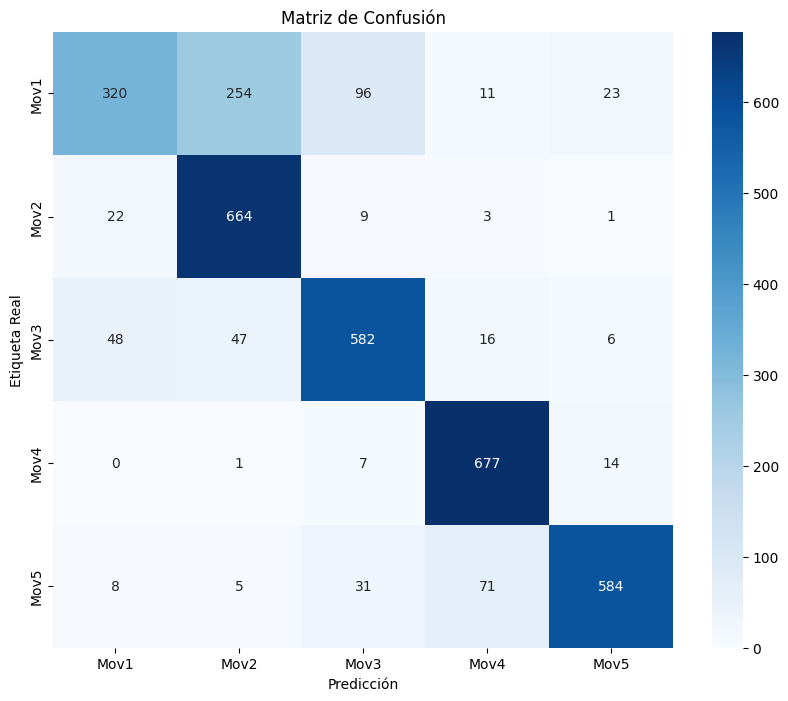


Reporte de Clasificación:
              precision    recall  f1-score   support

        Mov1       0.80      0.45      0.58       704
        Mov2       0.68      0.95      0.80       699
        Mov3       0.80      0.83      0.82       699
        Mov4       0.87      0.97      0.92       699
        Mov5       0.93      0.84      0.88       699

    accuracy                           0.81      3500
   macro avg       0.82      0.81      0.80      3500
weighted avg       0.82      0.81      0.80      3500


Precisión Global: 80.77%


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model


test_data = pd.read_csv('27SujetosLecturasEMG/S1_700_LecturasTest.csv', header=None)
X_test = test_data.values

y_test = np.zeros(3500)  #3812 muestras en total
y_test[1:700] = 0       # Movimiento 1 (reposo)
y_test[701:1400] = 1    # Movimiento 2 (Abducción de los dedos)
y_test[1401:2100] = 2    # Movimiento 3 (dedos flexionados)
y_test[2101:2800] = 3    # Movimiento 4 (señala con índice)
y_test[2801:3500] = 4    # Movimiento 5 (envoltura media)


X_test = scaler.transform(X_test)  

#  predicciones
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

#  matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# grafica
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Mov1', 'Mov2', 'Mov3', 'Mov4', 'Mov5'],
            yticklabels=['Mov1', 'Mov2', 'Mov3', 'Mov4', 'Mov5'])
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.show()


print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_classes, 
                           target_names=['Mov1', 'Mov2', 'Mov3', 'Mov4', 'Mov5']))

# 8. Precisión general
accuracy = np.sum(y_pred_classes == y_test) / len(y_test)
print(f"\nPrecisión Global: {accuracy*100:.2f}%")